In [28]:
#Import packages for single-cell analysis

import os, scanpy as sc, numpy as np, pandas as pd
sc.settings.verbosity = 3
sc.set_figure_params(dpi=130)

#Define file-path layout

PROJECT_ROOT = os.path.abspath(".")
DATA_DIR = os.path.join(PROJECT_ROOT, "data", "cellxgene")
OUT_DIR = os.path.join(PROJECT_ROOT, "outputs")
FIG_DIR = os.path.join(OUT_DIR, "figures")
H5AD_DIR = os.path.join(OUT_DIR, "h5ad")

#Create output directory
os.makedirs(FIG_DIR, exist_ok=True); os.makedirs(H5AD_DIR, exist_ok=True)

#Set default figure directory

sc.settings.figdir = FIG_DIR

#Define input file path

SL040_PATH = os.path.join(DATA_DIR, "SL040.h5ad")

#Confirm that the input data exists

print("Data present?")
print("  SL040:", os.path.exists(SL040_PATH))


Data present?
  SL040: True


In [30]:
#Import ScanPy and NumPy

import scanpy as sc
import numpy as np

#Find which column in adata.obs represents a batch variable

def detect_batch_key(adata):
    for c in ["sample", "tumor", "subject", "batch", "donor"]:
        if c in adata.obs and adata.obs[c].nunique() > 1:
            return c
    for c in adata.obs.columns:
        if adata.obs[c].dtype.name in ("category", "object") and adata.obs[c].nunique() > 1:
            return c
    return None


#Generate standard Scanpy QC plots

def qc_plots(adata, tag):
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True,
        save=f"_{tag}_qc_violin.png"
    )
    sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", save=f"_{tag}_qc_scatter_counts_vs_mt.png")
    sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", save=f"_{tag}_qc_scatter_counts_vs_genes.png")


#Run Scanpy preprocessing and integration workflow

def standard_pipeline(adata, tag, mito_thresh=15, n_hvg=4000, n_pcs=50, res=0.8):
    

    print(f"🚀 Running preprocessing for {tag} (no Harmony correction)...")

    #Compute QC metrics and plot before filtering
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=None, inplace=True)
    qc_plots(adata, tag=f"{tag}_BEFORE")

    #Filter out low-quality or high-mito cells
    
    filt = (adata.obs["n_genes_by_counts"] >= 200) & (adata.obs["pct_counts_mt"] < mito_thresh)
    adata = adata[filt].copy()
    print(f"✅ Filtered dataset shape: {adata.shape}")

    #Plot after filtering

    qc_plots(adata, tag=f"{tag}_AFTER")

    #Normalize and log-transform
    
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    #Identify highly variable genes
    
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=n_hvg, subset=True)
    print(f"✅ Retained {adata.n_vars} highly variable genes")

    #Scale genes and run PCA
    
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, n_comps=n_pcs)
    print("✅ PCA completed")

    #Build neighborhood graph, run UMAP, Leiden clustering 
    
    sc.pp.neighbors(adata, use_rep="X_pca", n_neighbors=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=res)
    print("✅ UMAP and Leiden clustering completed")

    #Save diagnostic plots 
    
    sc.pl.umap(adata, color=["n_genes_by_counts", "pct_counts_mt", "leiden"], save=f"_{tag}_UMAP_qc.png")

    print(f"🎯 Finished pipeline for {tag}")
    return adata


In [31]:

# Load raw single-cell dataset (SLO40.h5ad) into memory

assert os.path.exists(SL040_PATH)
ad_sl040_raw = sc.read_h5ad(SL040_PATH)
ad_sl040_raw.var_names_make_unique()

#Print dataset dimensions and column preview

print("SL040 raw shape:", ad_sl040_raw.shape)
print("SL040 obs columns:", list(ad_sl040_raw.obs.columns)[:15])

SL040 raw shape: (135482, 58234)
SL040 obs columns: ['Fluorescence', 'Location', 'MitoFraction', 'NeftelClass', 'UnsplicedFraction', 'Zone', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'total_genes']


In [32]:
#Inspect gene names

ad_sl040_raw.var_names[:10]


Index(['ENSG00000223972', 'ENSG00000227232', 'ENSG00000278267',
       'ENSG00000284332', 'ENSG00000268020', 'ENSG00000240361',
       'ENSG00000233750', 'ENSG00000268903', 'ENSG00000269981',
       'ENSG00000241860'],
      dtype='object')

In [33]:
#Inspect column names

ad_sl040_raw.var.columns[:10]


Index(['Accession', 'Chromosome', 'End', 'Gene', 'Start',
       'feature_is_filtered', 'feature_name', 'feature_reference',
       'feature_biotype', 'feature_length'],
      dtype='object')

Number of mitochondrial genes detected: 37
count    135482.000000
mean          4.673527
std           4.379080
min           0.000000
25%           1.736914
50%           3.450395
75%           6.059514
max          25.190445
Name: pct_counts_mt, dtype: float64


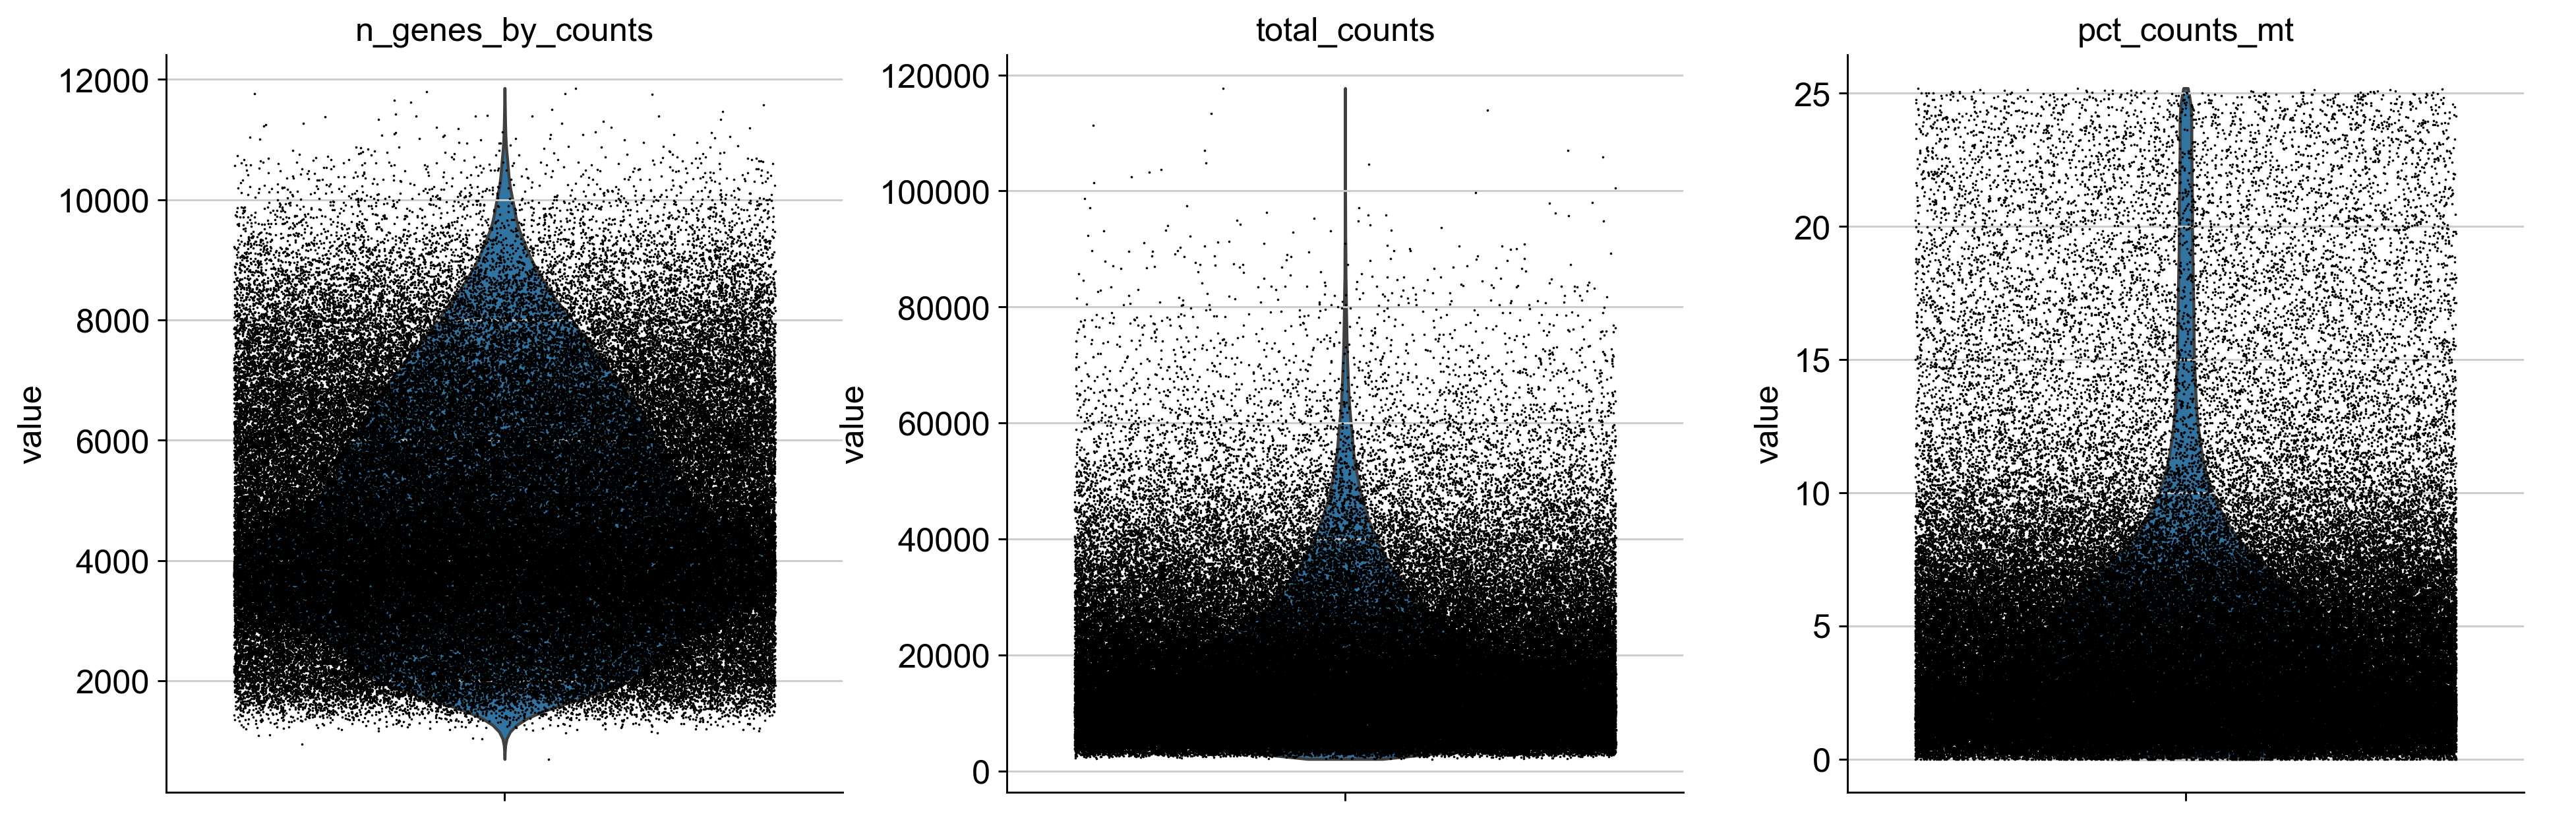

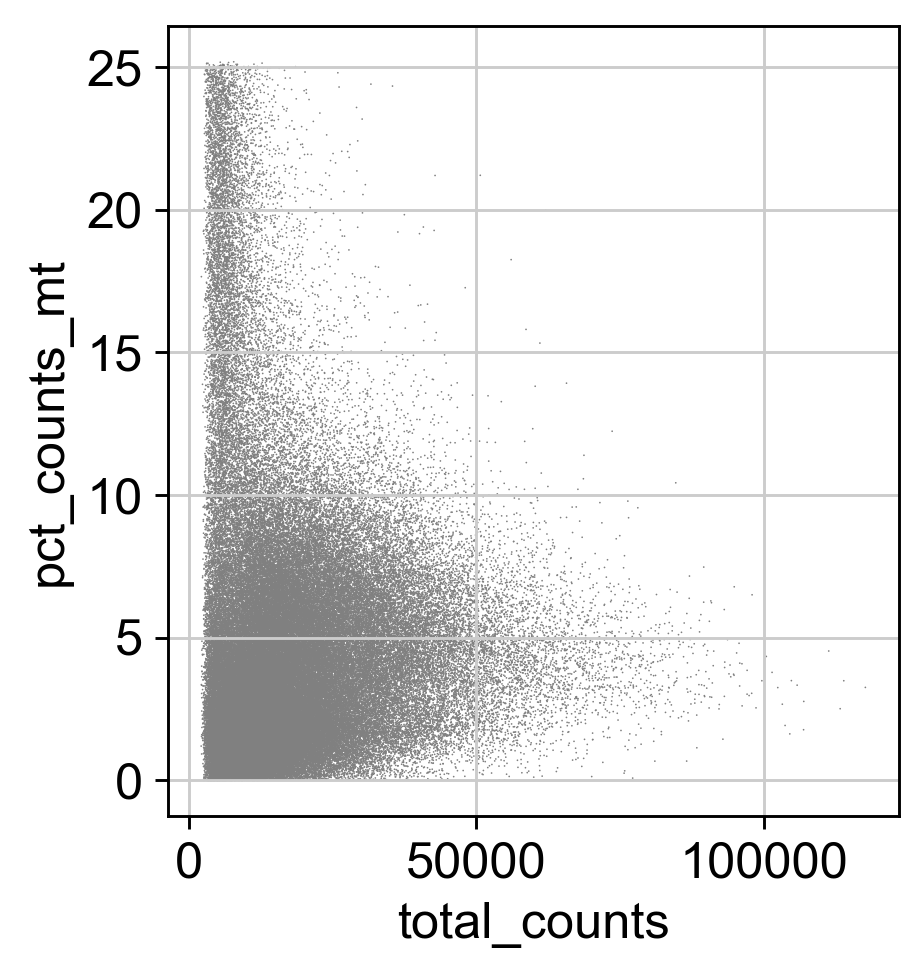

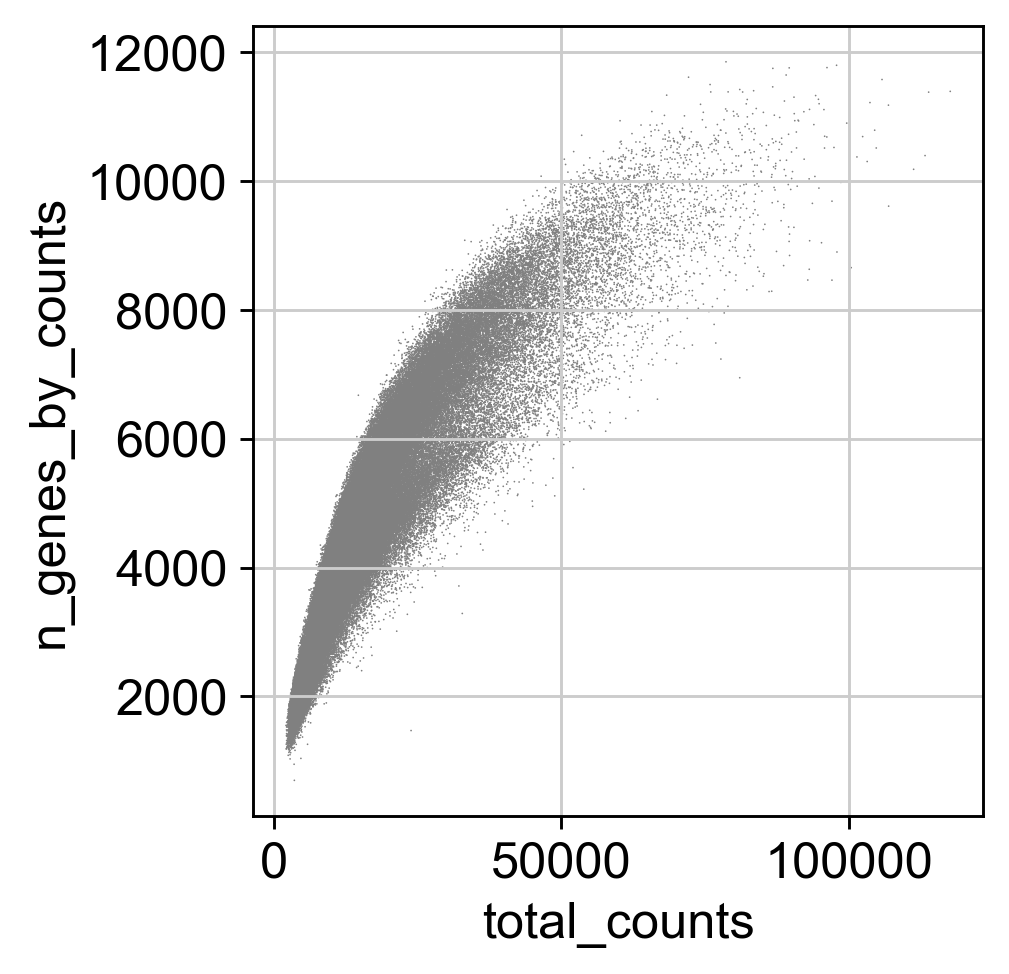

In [34]:
#Flag mitochondrial genes using gene symbols

ad_sl040_raw.var['mt'] = ad_sl040_raw.var['feature_name'].str.upper().str.startswith('MT-')
print("Number of mitochondrial genes detected:", ad_sl040_raw.var['mt'].sum())

#Recalculate per-cell QC metrics

sc.pp.calculate_qc_metrics(ad_sl040_raw, qc_vars=['mt'], inplace=True)

# Summarize distribution of mitochondrial percentages across all cells

print(ad_sl040_raw.obs['pct_counts_mt'].describe())

# Generate QC plots

qc_plots(ad_sl040_raw, tag="SL040_BEFORE_manual")


In [35]:
#Set the mitochondrial percentage cutoff to 10%

mito_thresh = 10

#Apply a filter mask

filt_mask = (ad_sl040_raw.obs.n_genes_by_counts >= 200) & (ad_sl040_raw.obs.pct_counts_mt < mito_thresh)
ad_sl040 = ad_sl040_raw[filt_mask].copy()

#Print the new dataset dimensions

print("SL040 after filter shape:", ad_sl040.shape)

SL040 after filter shape: (123329, 58234)


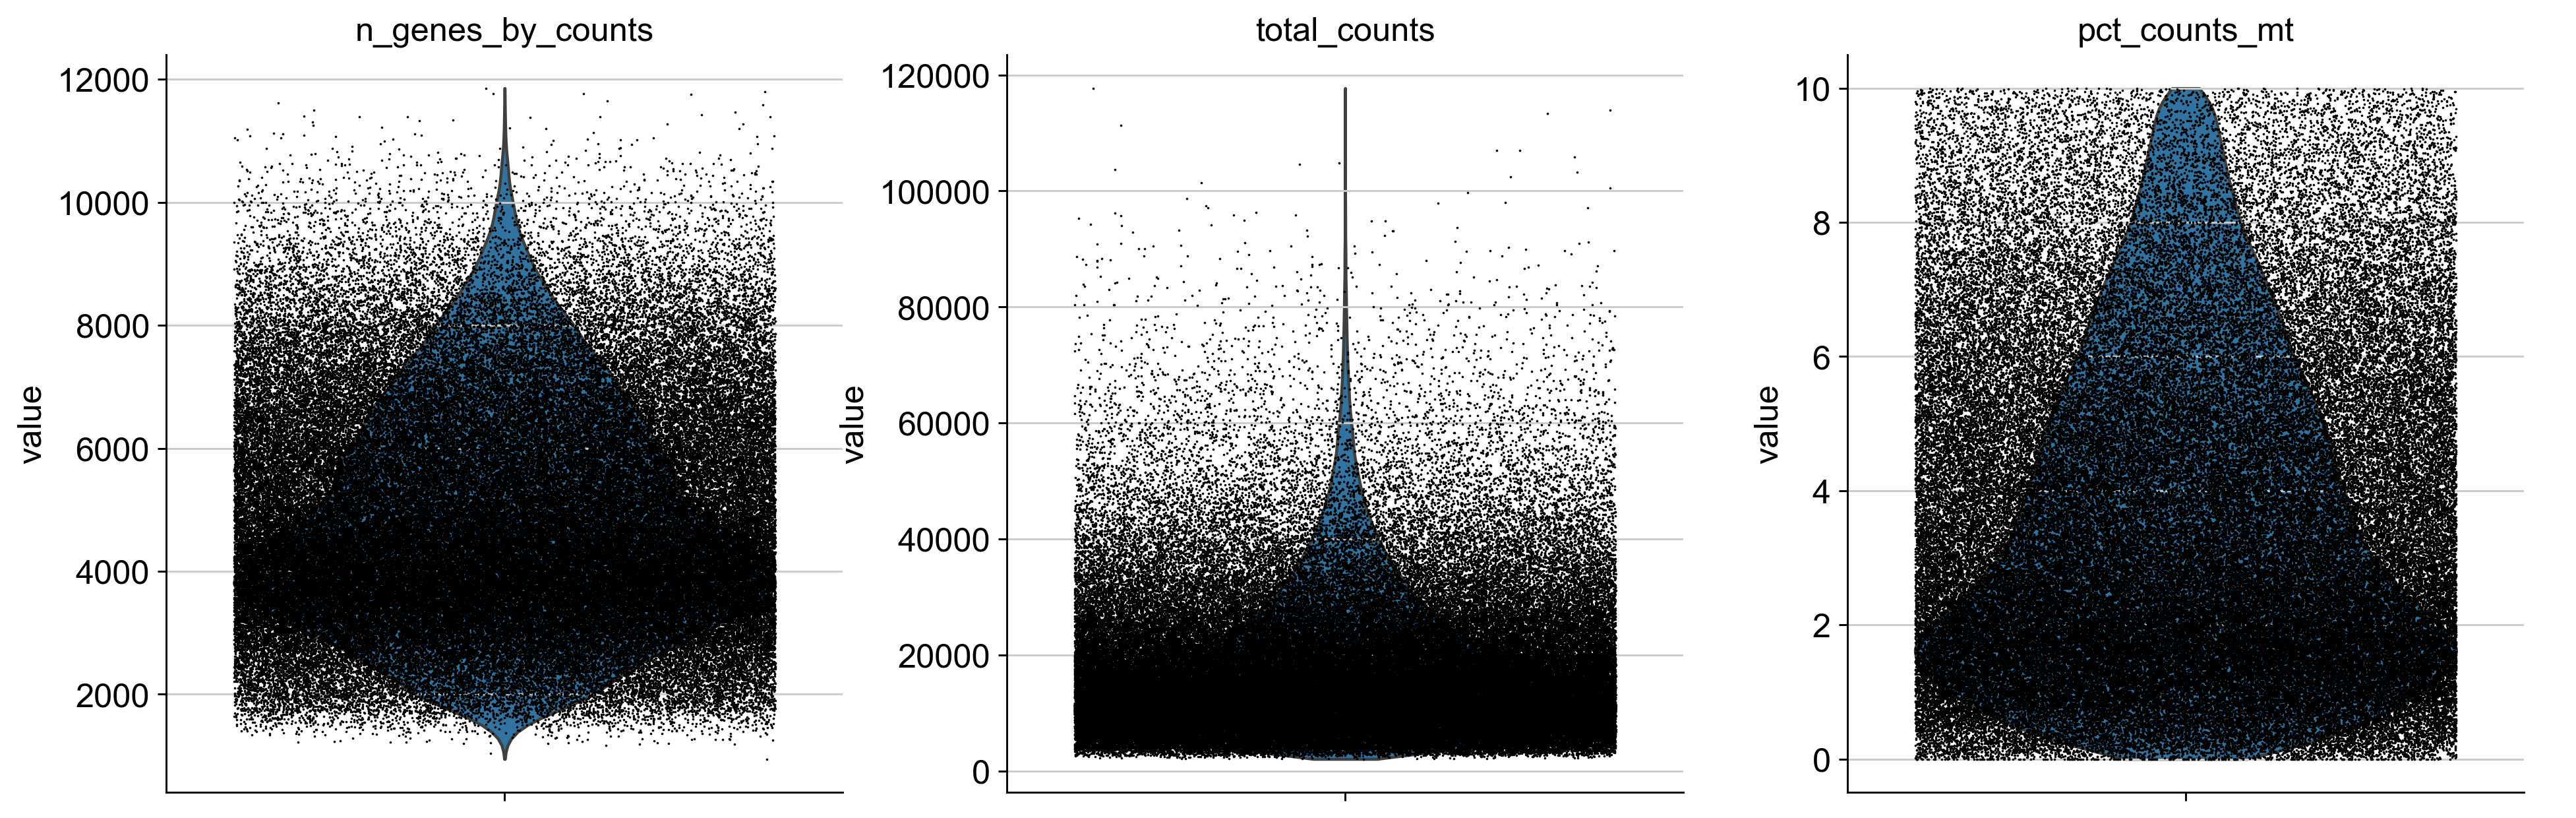

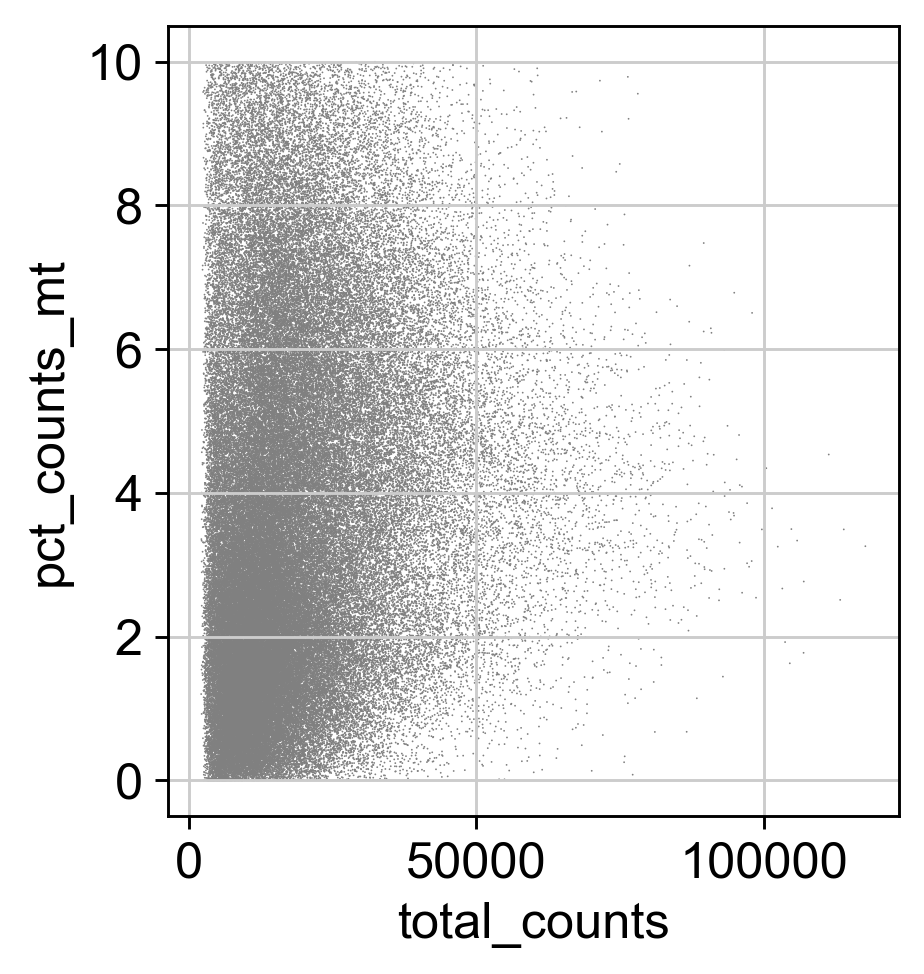

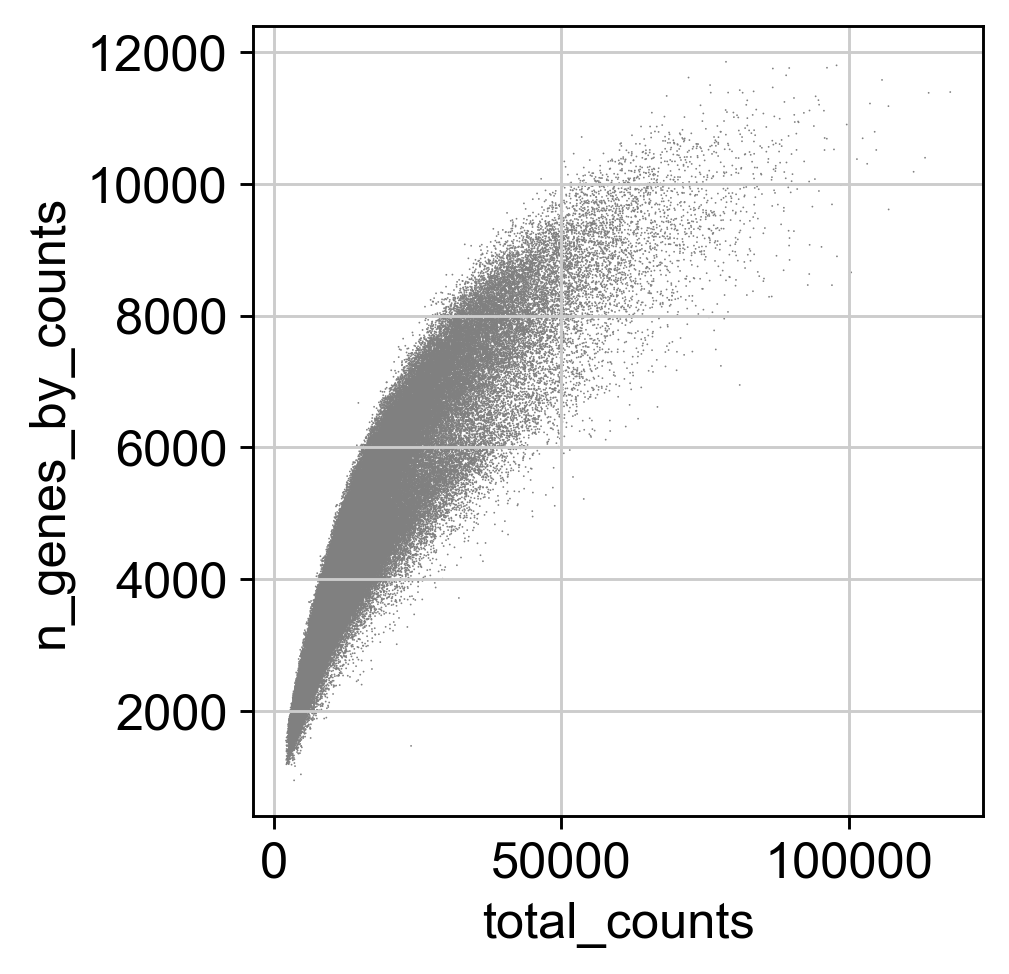

In [37]:
#Generate QC plots for filtered dataset

qc_plots(ad_sl040, tag="SL040_AFTER_manual")

computing PCA
    with n_comps=50
    finished (0:03:40)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:10:24)
running Leiden clustering


/var/folders/t7/vzbzd0xj40jbwddqp7614wm80000gn/T/ipykernel_41263/3942056328.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(ad_sl040, resolution=0.8)


    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:18:23)


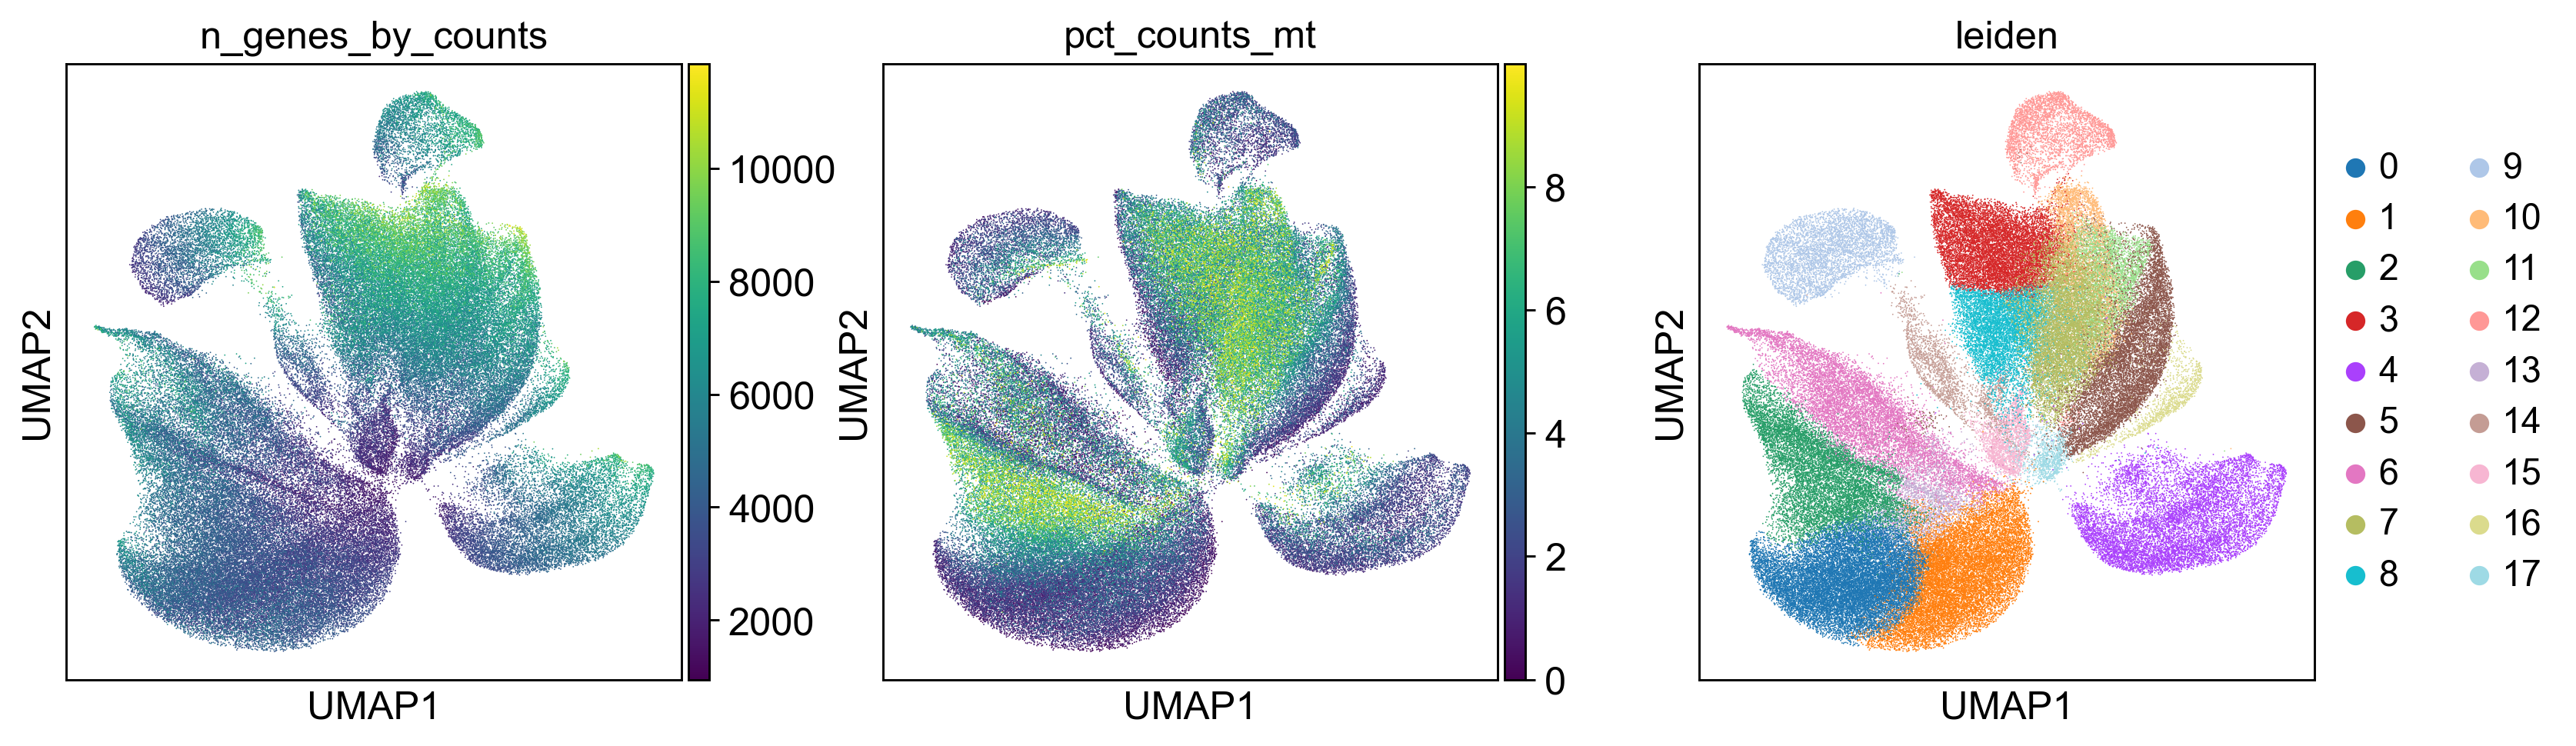

✅ Saved single-dataset object.


In [38]:
# Run PCA

sc.tl.pca(ad_sl040, n_comps=50)

#Neighborhood graph, UMAP, and clusters

sc.pp.neighbors(ad_sl040, use_rep="X_pca", n_neighbors=30)
sc.tl.umap(ad_sl040)
sc.tl.leiden(ad_sl040, resolution=0.8)

# Plot UMAP

sc.pl.umap(ad_sl040, color=["n_genes_by_counts", "pct_counts_mt", "leiden"], save="_SL040_UMAP.png")

# Save final object

ad_sl040.write(os.path.join(H5AD_DIR, "SL040_final.h5ad"))
print("✅ Saved single-dataset object.")
